In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import display, HTML
from Bio import SeqIO
import os
#from astropy import units as u
import sys
from readpaf import parse_paf
from collections import Counter, defaultdict
from tqdm import tqdm

#import sv

#from itables import init_notebook_mode
#init_notebook_mode(all_interactive=True)
pd.set_option('display.max_columns', None)

def to_latex(df, data, refname):
    latex = ""
    df.index = df.index.map(lambda x: f'\\{x}')
    df.columns = df.columns.str.replace(' ', '\\\\')
    df.columns = df.columns.str.replace('%', '\%')
    df.columns = df.columns.map(lambda x: '\makecell{' + x + '}')
    #df = df.astype(str).map(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)
    latex += df.to_latex(escape=False, label=f'tab:{refname}', caption=data, float_format = lambda x: '{:0.2f}'.format(x) if pd.notna(x) else '-')
    #latex += df.to_latex(float_format = lambda x: '{:0.2f}'.format(x) if pd.notna(x) else '-')
    latex += '\n'
    return latex

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_mapping_quality(df, ax, tool, reads):
    marker = { 'blend': 'o', 'minimap': 's', 'winnowmap': 'x', 'shmap': 'd', 'mm2-fast': 'v', 'mapquik': 'p' } 

    df_sorted = df.sort_values(by="mapping_quality", ascending=False).reset_index(drop=True)
    #display(df_sorted.head(10))

    total_reads = len(df)
    fraction_mapped = []
    error_rates = []
    wrongs = 0
    
    for i in range(total_reads):
        if df_sorted.iloc[i]["is_correct"] == False:
            wrongs += 1
        if i == total_reads-1 or df_sorted.iloc[i]["mapping_quality"] != df_sorted.iloc[i+1]["mapping_quality"]:
            error_rates.append(wrongs / (i+1))
            fraction_mapped.append((i+1) / reads)

    #print(reads, total_reads, wrongs)
    #print(error_rates, fraction_mapped)

    # Plot the results
    tool_marker = marker[ tool.split('-')[0] ]
    ax.plot(error_rates, fraction_mapped, marker=tool_marker, linestyle='-', label=tool)
    plt.xlim(1e-5, 1e-1)
    plt.ylim(0.9, 1)
    ax.set_xscale('log')  # Log scale for error rate
    ax.set_xlabel("Error rate of mapped reads")
    ax.set_ylabel("Fraction of mapped reads")
    ax.set_title("Fraction of Mapped Reads vs Error Rate")
    
    # Customize x-axis labels to show 10^-i without coefficients
    def log_format(x, pos):
        exponent = int(np.log10(x))
        return f'$10^{{{exponent}}}$'
    
    ax.xaxis.set_major_formatter(FuncFormatter(log_format))

    ax.grid(True, which="both", linestyle="--", linewidth=0.5)



In [10]:
#def perc(a, b):
#    if b == 0:
#        return np.nan
#    return 100.0 * a / b

def fasta2df(fn):
    seqs = SeqIO.parse(fn, "fasta")
    df = pd.DataFrame((str(s.id), str(s.seq)) for s in seqs)
    df.columns = ["ID", "Sequence"]
    return df

#def is_overlapping(a, sv_row):
#    return a.GT_from <= sv_row['END'] and sv_row['POS'] <= a.GT_to 
    
min_overlap = 0.1

def get_overlap(a):
     if a.GT_ref != a.target_name:
         return False
     if a.GT_strand != a.strand:
         return False
     union_from = min(a.GT_from, a.target_start)
     union_to = max(a.GT_to, a.target_end)

     intersect_from = max(a.GT_from, a.target_start)
     intersect_to = min(a.GT_to, a.target_end)
     overlap = max(0.0, (intersect_to - intersect_from) / (union_to - union_from))
     return overlap

def read_paf(pref, reads, experiment, tool, ax):
    paf_file = pref.parent / (pref.name + '.paf')
    #print(paf_file)
    no_GT = False
    if not paf_file.exists():
        raise Exception(f"File does not exist or is empty: {paf_file}")
    with open(paf_file) as handle:
        df = parse_paf(handle, dataframe=True)
        df['experiment'] = experiment
        df['tool'] = tool
        try:
            df[ ['read_name', 'GT_ref', 'GT_from', 'GT_to', 'GT_strand'] ] = df['query_name'].str.split('!', expand=True)
            df['GT_from'] = df['GT_from'].astype(int)
            df['GT_to'] = df['GT_to'].astype(int)
            df['overlap'] = df.apply(get_overlap, axis=1)
            df['is_correct'] = df['overlap'] >= min_overlap
            #df['is_correct_labels'] = df.apply(lambda x: is_correct_labels(x, orig_l, mutated_l), axis=1)
            #df['is_correct'] = df.apply(lambda x: is_correct_labels(x, orig_l, mutated_l), axis=1)
            #df['start_diff'] = df.target_start - df.GT_from  # TODO: different coordinate systems!
            #df['end_diff'] = df.target_end - df.GT_to  # TODO: different coordinate systems!
            #df['read_sv'] = 'none' # df.apply(lambda x: read_falls_on_what_sv(x, vcf_df), axis=1)
        except Exception as e:
            #display(e)
            df['read_name'] = df['query_name']
            df['GT_ref'] = np.NaN
            df['GT_from'] = np.NaN
            df['GT_to'] = np.NaN
            df['GT_strand'] = np.NaN
            df['overlap'] = np.NaN
            df['is_correct'] = True
            #df['is_correct_labels'] = True
            #df['start_diff'] = 0
            #df['end_diff'] = 0
            #df['read_sv'] = 'none'
            no_GT = True
    df = df.sort_values(['read_name', 'residue_matches'], ascending=[True, False], ignore_index=True)
    #display(df)

    df = df[['read_name', 'mapping_quality', 'is_correct', 'alignment_block_length']]  # speeding up and freeing memory

    paf = defaultdict(int)
    paf['Mapped Q60'] = 0
    paf['Q<60 or missed'] = np.nan
    paf['Wrong Q60'] = 0
    #mapped_reads = 0
    #wrong = 0

    #def process_group(group_first_index, group_last_index):
    #    nonlocal mapped_reads, wrong
    #    group = df.loc[group_first_index:group_last_index]
    #    mapped_reads += 1
    #    if (group.mapping_quality == 60).all():
    #        paf['Mapped Q60'] += 1
    #        if not group.is_correct.all():
    #            paf['Wrong Q60'] += 1
    #    else:
    #        wrong += 1

    #group_first_i, group_read_name = 0, df.loc[0, 'read_name']
    #for i, a in df.iterrows():
    #    if a.read_name != group_read_name:
    #        process_group(group_first_i, i-1)
    #        group_first_i, group_read_name = i, a.read_name
    #process_group(group_first_i, len(df)-1)

    #df['is_q60'] = (df['mapping_quality'] == 60)

    
    df_max = df.loc[df.groupby('read_name')['alignment_block_length'].idxmax()]
    df_max = df_max.reset_index(drop=True)

    #grouped = df.groupby('read_name').agg(
    #    all_q60=('is_q60', 'all'),       # True if every row in the group is Q60
    #    all_correct=('is_correct', 'all')# True if every row in the group is correct
    #)
    mapped_reads = len(df_max)  # total number of read_name groups
    mapped_q60 = (df_max['mapping_quality'] == 60).sum()
    mapped_ql60 = (df_max['mapping_quality'] < 60).sum()
    wrong_q60 = ((df_max['mapping_quality'] == 60) & (df_max['is_correct'] == False)).sum()
    #wrong = (df_max['is_correct'] == False).sum()

    paf['Mapped Q60'] = int(mapped_q60)
    paf['Wrong Q60']  = int(wrong_q60)

    missed = reads - mapped_reads
    Ql60_or_missed = mapped_ql60 + missed
    #print('reads=', reads, 'mapped_reads=', mapped_reads, 'mapped_q60=', mapped_q60, 'missed=', missed, 'Ql60_or_missed=', Ql60_or_missed)
    #paf['Q<60 or missed'] = wrong_or_missed
    paf['Q<60 or missed'] = "{:.1f}%".format(100 * Ql60_or_missed / reads)

    if no_GT:
        paf['Wrong Q60'] = 'n/a'

    #for name, group in df.groupby('read_name'):
    #    if len(group) > 1:
    #        print(name)
    #        display(group)
    
    plot_mapping_quality(df_max, ax, tool, reads)

    return pd.Series(paf, dtype='object')
    
index_time_col = 'Index [sec]'
map_time_col = 'Map [sec]'
memory_col = 'Memory [GB]'

def read_times(pref):
    times = {}
    with open(str(pref) + '.index.time') as f_index_time:
        index_time, index_mem = map(float, f_index_time.readline().split())
        times[index_time_col] = index_time #* u.second
        #times['index_mem'] = index_mem / 2**20
        with open(str(pref) + '.time') as f_time:
            total_time, total_mem = map(float, f_time.readline().split())
            #times['time total'] = total_time #* u.second
            times[map_time_col] = total_time - times[index_time_col]
            times[memory_col] = (total_mem / 2**20) #* u.GB
    return pd.Series(times, dtype='object').map('{:.1f}'.format)

def get_comparison_table(main_dir: Path, refname, experiment: Path, tools):
    empty_cell = -1
    alldf = pd.DataFrame()
    alldf.name = experiment
    ref = fasta2df(Path('refs') / (refname + '.fa'))
    reads = fasta2df(Path('reads') / (str(experiment) + '.fa'))

    rows = []
    fig, ax = plt.subplots()

    for tool in tqdm(tools, desc=f'Tools for {experiment}', leave=False):
        d = Path(main_dir) / tool / experiment / tool
        #d = Path(main_dir) / experiment / tool / tool
        row = pd.Series({
            'tool': tool,
        })
        paf = read_paf(d, len(reads), experiment, tool, ax)
        row = pd.concat([row, paf])
        try:
            row = pd.concat([row, read_times(d)])   # .time, .index.time
        except Exception as e:
            print(f"An error occurred while reading times {d}: {e}")
            row[index_time_col] = empty_cell
            row[map_time_col] = empty_cell
            row[memory_col] = empty_cell
        rows.append(row)
        #except Exception as e:
        #    print(f"An error occurred while reading PAF {d}: {e}")
    ax.legend()
    plt.show()

    alldf = pd.DataFrame(rows)
    alldf = alldf.set_index('tool')
    alldf.index.name = None
    return alldf

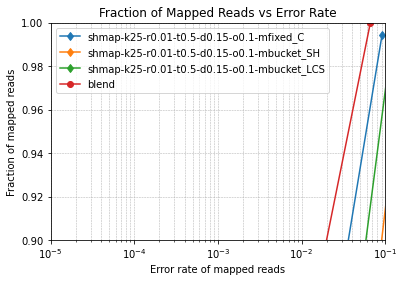

,Mapped Q60,Q<60 or missed,Wrong Q60,Index [sec],Map [sec],Memory [GB]
shmap-k25-r0.01-t0.5-d0.15-o0.1-mfixed_C,2974,64.0%,0,0.2,17.7,0.2
shmap-k25-r0.01-t0.5-d0.15-o0.1-mbucket_SH,2762,66.6%,1,0.1,10.0,0.2
shmap-k25-r0.01-t0.5-d0.15-o0.1-mbucket_LCS,2936,64.5%,1,0.2,21.4,0.2
blend,4097,50.4%,3,0.8,125.9,0.2


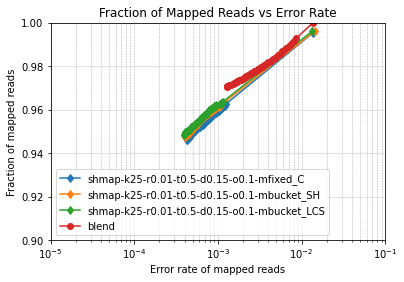

,Mapped Q60,Q<60 or missed,Wrong Q60,Index [sec],Map [sec],Memory [GB]
shmap-k25-r0.01-t0.5-d0.15-o0.1-mfixed_C,356167,5.4%,152,15.5,97.6,5.2
shmap-k25-r0.01-t0.5-d0.15-o0.1-mbucket_SH,356645,5.3%,145,15.3,68.3,5.2
shmap-k25-r0.01-t0.5-d0.15-o0.1-mbucket_LCS,357010,5.2%,139,15.2,117.8,5.2
blend,365460,2.9%,467,51.2,253.7,5.4


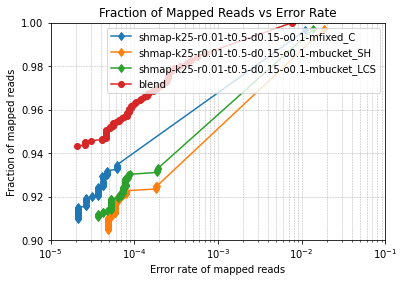

,Mapped Q60,Q<60 or missed,Wrong Q60,Index [sec],Map [sec],Memory [GB]
shmap-k25-r0.01-t0.5-d0.15-o0.1-mfixed_C,187661,9.0%,4,16.5,66.8,5.2
shmap-k25-r0.01-t0.5-d0.15-o0.1-mbucket_SH,186634,9.5%,9,15.0,46.1,5.2
shmap-k25-r0.01-t0.5-d0.15-o0.1-mbucket_LCS,187874,8.9%,7,15.7,87.2,5.2
blend,194588,5.7%,4,52.6,194.9,5.4


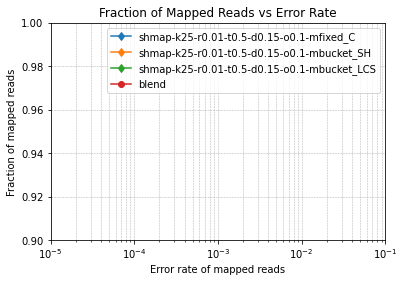

,Mapped Q60,Q<60 or missed,Wrong Q60,Index [sec],Map [sec],Memory [GB]
shmap-k25-r0.01-t0.5-d0.15-o0.1-mfixed_C,516753,6.6%,n/a,12.4,208.8,5.2
shmap-k25-r0.01-t0.5-d0.15-o0.1-mbucket_SH,515966,6.7%,n/a,16.0,111.5,5.2
shmap-k25-r0.01-t0.5-d0.15-o0.1-mbucket_LCS,516685,6.6%,n/a,14.8,378.3,5.2
blend,521759,5.7%,n/a,51.9,465.8,5.4


In [12]:
main_dir = Path('out_small')
#tools = ['mm2-fast', 'winnowmap']
#tools = ['shmap-k25-r0.05-t0.4-diff0.05', 'minimap', 'blend', 'mapquik', 'mm2-fast', 'winnowmap'] #, ['shmap-k25-r0.05-t0.4-diff2', 'shmap-k25-r0.05-t0.4-diff0.02', 'shmap-k25-r0.05-t0.4-diff0.15', 'blend'] #, 'shmap-diff0.02', 'shmap-diff0.1'] #, 'blend', 'winnowmap', 'minimap', 'mapquik', 'mm2-fast'] #, 'shmap-diff0.15', 'shmap-diff0.02', 'shmap'] #, 'shmap-MIN_DIFF-002']  # 'shmap-noprune',  'shmap-k25-r0.05-t0.4-diff0.15', 'shmap-k25-r0.05-t0.5-diff0.1'
#tools = ['shmap-k25-r0.05-t0.4-diff0.05',
#         'shmap-k25-r0.03-t0.5-diff0.05',
#         'shmap-k25-r0.05-t0.5-d0.15-o0.1-mfixed_C',
#         'shmap-k25-r0.05-t0.5-d0.15-o0.1-mbucket_SH',    
#         'shmap-k25-r0.05-t0.5-d0.15-o0.1-mbucket_LCS',    
#         'blend'] #['minimap']#, , 'shmap-k25-r0.05-t0.4-diff0.02']
tools = [
         'shmap-k25-r0.01-t0.5-d0.15-o0.1-mfixed_C',
         'shmap-k25-r0.01-t0.5-d0.15-o0.1-mbucket_SH',    
         'shmap-k25-r0.01-t0.5-d0.15-o0.1-mbucket_LCS',    
         'blend'] #['minimap']#, , 'shmap-k25-r0.05-t0.4-diff0.02']
experiments = [
    ('chrY',  'chrY-readschrY-a?-d2-l?'),
    ('chm13', 'chm13-readshg002-a?-d1-l?'),
    ('chm13', 'chm13-readschm13-a?-d1-l?'),
    ('chm13', 'HG002_small'),
]

pd.set_option('display.width', 100)
css = """ <style> table { font-family: "Courier New", Courier, monospace; } </style> """
display(HTML(css))
dfs = []
keys = []
for refname, data in experiments:
    df = get_comparison_table(main_dir=main_dir, refname=refname, experiment=data, tools=tools).round(2)
    dfs.append(df)
    keys.append(data)
    df_styled = df.style.set_caption(data)
    display(df_styled)
DF = pd.concat(dfs, keys=keys)
#display(DF)
DF.to_latex('evals-table.tex', escape=True, multirow=False)

In [115]:
main_dir = Path('out')
#tools = ['mm2-fast', 'winnowmap']
tools = ['minimap', 'winnowmap', 'blend', 'mapquik', 'shmap-noprune', 'shmap']
#tools = ['minimap', 'shmap-noprune', 'shmap']
experiments = [
    ('t2tChrY', 't2tChrY-readst2tChrY-a0.99-d10-l10000'),
    ('chm13',   'chm13-readschm13-a0.99-d1-l10000'),
    ('t2tChrY', 't2tChrY-readst2tChrY-a0.99-d10-l24000'),
    ('chm13',   'HG002_24kb_10G'),
]

pd.set_option('display.width', 100)
css = """ <style> table { font-family: "Courier New", Courier, monospace; } </style> """
display(HTML(css))
dfs = []
keys = []
for refname, data in experiments:
    df = get_comparison_table(main_dir=main_dir, refname=refname, experiment=data, tools=tools).round(2)
    dfs.append(df)
    keys.append(data)
    df_styled = df.style.set_caption(data)
    display(df_styled)
DF = pd.concat(dfs, keys=keys)
display(DF)
DF.to_latex('evals-table.tex', escape=True, multirow=False)

FileNotFoundError: [Errno 2] No such file or directory: 'refs/t2tChrY.fa'

In [5]:
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

df_high = df_styled.apply(highlight_max).set_caption(data)
display(df_high.to_latex(escape=False))

display(df_high)

NameError: name 'df_styled' is not defined

In [109]:
DF = pd.concat(dfs, keys=keys)
display(DF)
DF.to_latex('evals-table.tex', escape=True)

Mapped Q60  Q<60 or missed Wrong Q60 Index [sec]  \
t2tChrY-readst2tChrY-a0.99-d10-l10000 jaccmap         43528               0        12         0.7   
                                      minimap         20572               0         0         1.6   
                                      mapquik         25907            7727         0         0.5   
                                      blend           29461               0       132         1.1   
                                      winnowmap       34803               0        38         2.5   
chm13-readschm13-a0.99-d0.1-l10000    jaccmap         30278               0         1        41.5   
                                      minimap         28233               0         0        79.2   
                                      mapquik             8           17378         8        30.3   
                                      blend           29288               2        19        51.4   
                                      winnowmap       29501               1         4       120.1   
t2tChrY-readst2tChrY-a0.99-d1-l24000  jaccmap          2198               0         1         0.6   
                                      minimap           935               0         0         1.7   
                                      mapquik          1472              84         0         0.5   
                                      blend            1521               0         6         1.1   
HG002_24kb                            jaccmap         21522              52       n/a        43.2   
                                      minimap         20365               3       n/a        78.7   
                                      mapquik           510            9894       n/a        30.4   
                                      blend           20752               9       n/a        51.2   

                                                Map [sec] Memory [GB]  
t2tChrY-readst2tChrY-a0.99-d10-l10000 jaccmap       117.1         0.4  
                                      minimap      1153.4         0.7  
                                      mapquik         4.7         1.5  
                                      blend         371.8         0.6  
                                      winnowmap   54016.1        16.4  
chm13-readschm13-a0.99-d0.1-l10000    jaccmap        15.5        12.3  
                                      minimap        60.9        10.2  
                                      mapquik         3.1         4.2  
                                      blend          13.0         5.4  
                                      winnowmap    1372.5         3.3  
t2tChrY-readst2tChrY-a0.99-d1-l24000  jaccmap         5.8         0.4  
                                      minimap       159.4         0.3  
                                      mapquik         0.5         1.5  
                                      blend          52.9         0.2  
HG002_24kb                            jaccmap        33.2        12.3  
                                      minimap       141.4        10.2  
                                      mapquik         6.6         4.2  
                                      blend          32.2         5.4

In [124]:
DF.to_latex('evals-table.tex', escape=True, multirow=False)

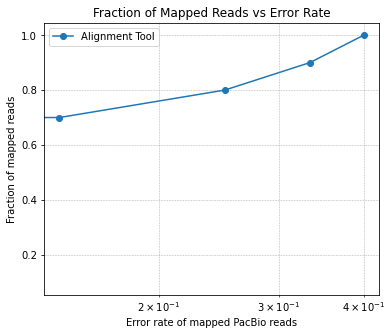

In [14]:
data = {
    "is_correct": [1, 0, 1, 1, 0, 1, 0, 1, 1, 0],
    "mapping_quality": [30, 20, 50, 40, 10, 60, 15, 35, 25, 5]
}
df = pd.DataFrame(data)
plot_mapping_quality(df)